<a href="https://colab.research.google.com/github/TrippleA001/Air-Quality-Index-for-Urban-vs-Rural-Nigeria/blob/main/Individual/Benin_PM10_pollutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
df= pd.ExcelFile("/content/drive/MyDrive/PM 2.5 and PM 10 Prediction for PhD Physics/Benin City's Data.xlsx")
data = pd.read_excel(df, 'Benin City Hourly')

Mounted at /content/drive/


In [3]:
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,01:00:00,25.08,96.35,999.88,1.43,238.48,18.5830,25.2245,31.5320
1,2021-05-01,02:00:00,24.99,96.33,999.34,1.39,241.08,19.0965,25.5050,32.4475
2,2021-05-01,03:00:00,24.92,96.33,998.93,1.38,244.26,22.2495,29.8830,38.7970
3,2021-05-01,04:00:00,24.83,96.39,998.80,1.44,246.40,22.0140,29.9435,38.9405
4,2021-05-01,05:00:00,24.79,96.42,998.89,1.53,249.46,25.4190,35.0155,46.0580
...,...,...,...,...,...,...,...,...,...,...
14555,2023-04-30,19:00:00,24.96,94.73,1002.20,1.47,258.52,37.2665,52.8340,67.3520
14556,2023-04-30,20:00:00,24.68,95.30,1002.70,1.52,257.01,25.7560,36.0780,42.9835
14557,2023-04-30,21:00:00,24.48,95.66,1003.02,1.55,253.30,15.0430,20.3340,25.1810
14558,2023-04-30,22:00:00,24.29,96.06,1003.15,1.56,246.64,17.3515,23.6275,28.4245


In [4]:
# summary statistics for the data used in buiding the ML algorithms
data.describe()

,Date,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
count,14560,14560.000000,14560.000000,14560.000000,14560.000000,14560.000000,14560.000000,14560.000000,14560.000000
mean,2022-04-06 20:42:59.340659456,25.597641,86.598331,1002.366482,1.717413,216.047383,35.541379,46.222973,56.487002
min,2021-05-01 00:00:00,13.890000,36.480000,996.590000,0.010000,0.020000,0.802000,1.547500,1.831500
25%,2021-10-16 00:00:00,23.790000,78.910000,1001.020000,1.360000,214.817500,16.809875,22.348000,28.260750
50%,2022-03-26 00:00:00,25.220000,91.670000,1002.350000,1.570000,232.655000,23.068500,32.112250,42.409500
75%,2022-09-15 00:00:00,27.570000,96.110000,1003.690000,2.010000,247.262500,32.840875,46.311250,62.281500
max,2023-04-30 00:00:00,33.470000,104.110000,1008.810000,5.530000,359.950000,359.310000,712.027500,829.829500
std,NaN,2.629874,11.605301,1.933066,0.658179,65.214237,40.493457,50.492372,54.846471


In [5]:
# Checking for duplicate values in the data
data.duplicated().sum()

np.int64(0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14560 entries, 0 to 14559
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            14560 non-null  datetime64[ns]
 1   Time            14560 non-null  object        
 2   Temp(deg)       14560 non-null  float64       
 3   Hum(%)          14560 non-null  float64       
 4   Pre(hPa)        14560 non-null  float64       
 5   WS (m/s)        14560 non-null  float64       
 6   Wind direction  14560 non-null  float64       
 7   PM1(µg/m^3)     14560 non-null  float64       
 8   PM2.5(µg/m^3)   14560 non-null  float64       
 9   PM10(µg/m^3)    14560 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.1+ MB


In [7]:
data.isnull().sum()

,0
Date,0
Time,0
Temp(deg),0
Hum(%),0
Pre(hPa),0
WS (m/s),0
Wind direction,0
PM1(µg/m^3),0
PM2.5(µg/m^3),0
PM10(µg/m^3),0


<Axes: ylabel='PM10(µg/m^3)'>

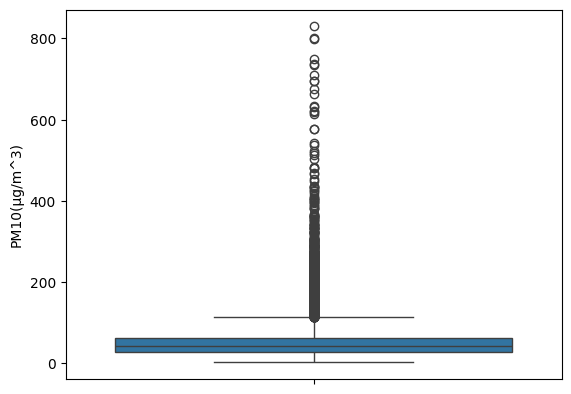

In [8]:
# Checking for outliers
sns.boxplot(data['PM10(µg/m^3)'])

In [9]:
#Outlier Detection using IQR
# Calculate the upper and lower limits
Q1 = data['PM10(µg/m^3)'].quantile(0.25)
Q3 = data['PM10(µg/m^3)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q3 - 3*IQR
upper = Q3 + 3*IQR

# Create arrays of Boolean values indicating the outlier rows
data = data[(data['PM10(µg/m^3)'] < upper) & (data['PM10(µg/m^3)'] > lower)]


In [10]:
data["Time"].apply(lambda x: isinstance(x, datetime.time)).sum()

np.int64(13316)

In [11]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
32,2021-05-02,"1 day, 0:00:00",24.95,96.32,1000.25,1.58,227.31,23.0565,33.3885,45.5935
54,2021-05-03,"1 day, 0:00:00",23.81,96.39,1001.06,1.40,223.98,18.4650,23.5190,29.1260
78,2021-05-04,"1 day, 0:00:00",24.00,95.80,1001.33,1.44,279.98,22.4425,31.2355,40.5525
102,2021-05-05,"1 day, 0:00:00",24.41,96.53,1002.40,1.63,221.55,7.1530,10.2970,13.8170
126,2021-05-06,"1 day, 0:00:00",23.80,96.39,1004.03,1.47,232.84,22.3090,28.7265,43.0560
...,...,...,...,...,...,...,...,...,...,...
14407,2023-04-23,"1 day, 0:00:00",24.94,96.65,1001.67,1.41,205.15,9.6685,13.2280,16.8660
14431,2023-04-24,"1 day, 0:00:00",25.04,88.55,1001.55,1.29,246.13,10.9750,14.5635,17.8850
14464,2023-04-26,"1 day, 0:00:00",24.50,96.12,1001.63,1.51,217.89,14.6845,18.6550,21.2815
14488,2023-04-27,"1 day, 0:00:00",23.88,96.79,1003.05,1.47,224.01,19.2175,24.8440,28.7340


In [12]:
data.loc[~data["Time"].apply(lambda x: isinstance(x, datetime.time)), "Time"] = "00:00:00"

In [13]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
32,2021-05-02,00:00:00,24.95,96.32,1000.25,1.58,227.31,23.0565,33.3885,45.5935
54,2021-05-03,00:00:00,23.81,96.39,1001.06,1.40,223.98,18.4650,23.5190,29.1260
78,2021-05-04,00:00:00,24.00,95.80,1001.33,1.44,279.98,22.4425,31.2355,40.5525
102,2021-05-05,00:00:00,24.41,96.53,1002.40,1.63,221.55,7.1530,10.2970,13.8170
126,2021-05-06,00:00:00,23.80,96.39,1004.03,1.47,232.84,22.3090,28.7265,43.0560
...,...,...,...,...,...,...,...,...,...,...
14407,2023-04-23,00:00:00,24.94,96.65,1001.67,1.41,205.15,9.6685,13.2280,16.8660
14431,2023-04-24,00:00:00,25.04,88.55,1001.55,1.29,246.13,10.9750,14.5635,17.8850
14464,2023-04-26,00:00:00,24.50,96.12,1001.63,1.51,217.89,14.6845,18.6550,21.2815
14488,2023-04-27,00:00:00,23.88,96.79,1003.05,1.47,224.01,19.2175,24.8440,28.7340


In [14]:
#  Convert DateTime values to time
i = 0
for x in data["Time"] :
  if not isinstance (x, datetime.time):
    data["Time"].iloc[i] = datetime.datetime.strptime(str(x), "%H:%M:%S").time()
  i += 1

In [15]:
data["Wind direction"].value_counts()

,count
Wind direction,
234.05,9
223.86,9
243.36,8
234.63,8
232.13,8
...,...
205.72,1
202.39,1
202.44,1


In [16]:
def wind_deg_to_str2(deg):
        arr = ['NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
        return arr[int(abs((deg - 11.25) % 360)/ 22.5)]

In [17]:
# Feature Engineering

data["DateTime"] = [datetime.datetime.combine(data["Date"].dt.date.iloc[i], data["Time"].iloc[i]) for i in range(len(data))]
data["Year"] =  data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Day"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour
data["Direction"] = data['Wind direction'].map(wind_deg_to_str2)
encoded_directions = pd.get_dummies(data.Direction, dtype=int)

In [18]:
data = pd.concat([data, encoded_directions], axis = 1)
data.set_index("DateTime", inplace=True)

In [19]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13867 entries, 2021-05-01 01:00:00 to 2023-04-30 23:00:00
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            13867 non-null  datetime64[ns]
 1   Time            13867 non-null  object        
 2   Temp(deg)       13867 non-null  float64       
 3   Hum(%)          13867 non-null  float64       
 4   Pre(hPa)        13867 non-null  float64       
 5   WS (m/s)        13867 non-null  float64       
 6   Wind direction  13867 non-null  float64       
 7   PM1(µg/m^3)     13867 non-null  float64       
 8   PM2.5(µg/m^3)   13867 non-null  float64       
 9   PM10(µg/m^3)    13867 non-null  float64       
 10  Year            13867 non-null  int32         
 11  Month           13867 non-null  int32         
 12  Day             13867 non-null  int32         
 13  Hour            13867 non-null  int32         
 14  Direction       138

In [20]:
data["Direction"].value_counts()

,count
Direction,
SW,4625
WSW,4176
SSW,1209
W,1202
NE,382
S,371
WNW,356
ENE,350
NNE,280


<Figure size 2500x1000 with 0 Axes>

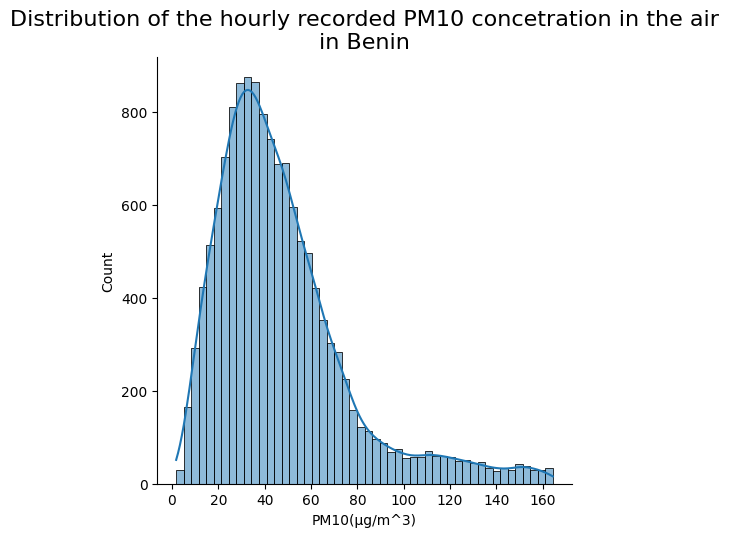

In [21]:
plt.figure(figsize=(25, 10))
sns.displot(data['PM10(µg/m^3)'],bins=50, kde=True , lw=5)
plt.title('Distribution of the hourly recorded PM10 concetration in the air\nin Benin',
          fontsize=16)
plt.show();

In [22]:
# find the daily average of PM10 contained in the air in any given hour
monthly_data = data[['PM10(µg/m^3)']]
monthly_data = monthly_data.resample('M').median()

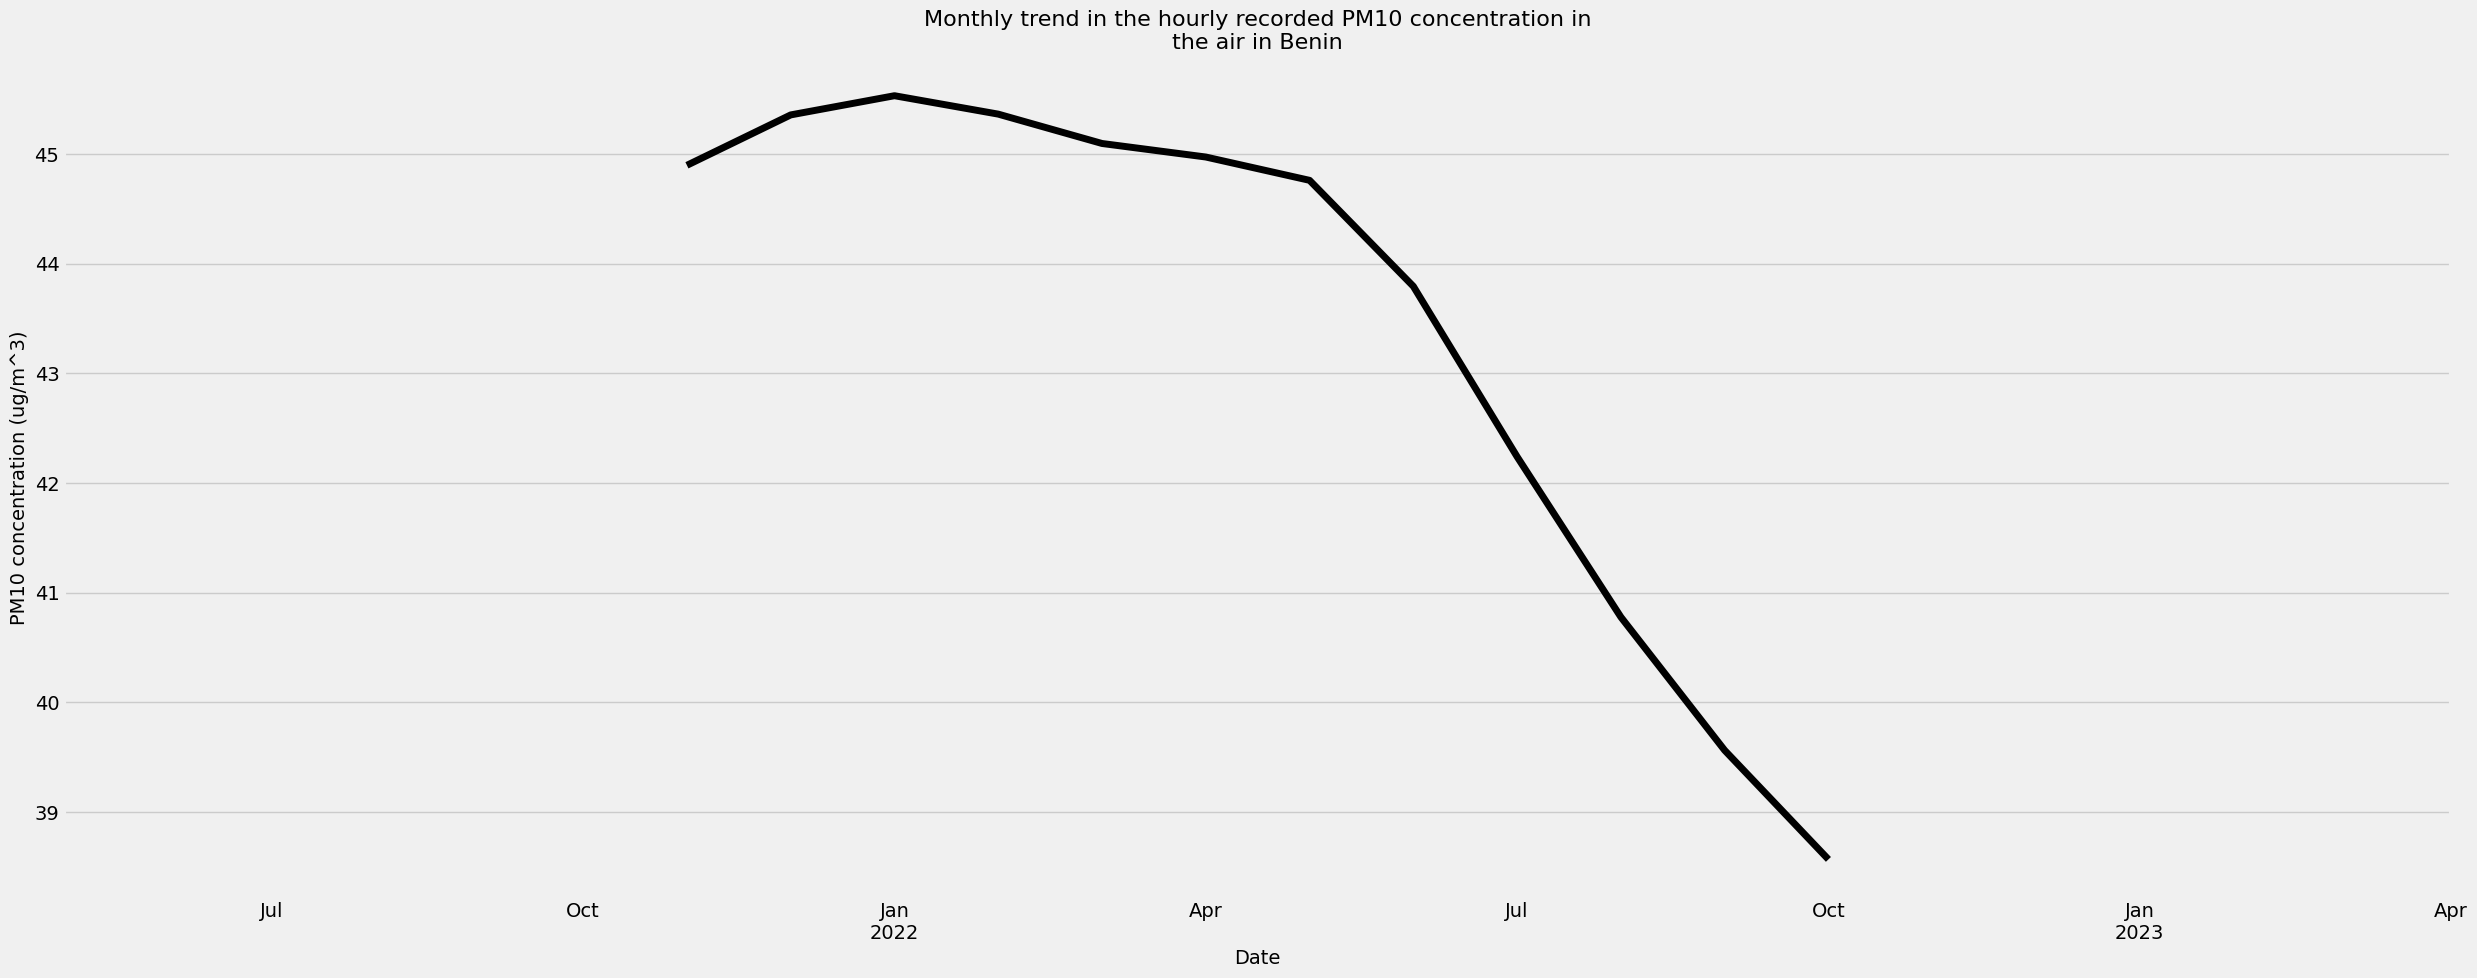

In [23]:
decomposition = seasonal_decompose(monthly_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25, 10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly trend in the hourly recorded PM10 concentration in\nthe air in Benin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

In [24]:
daily_data = data[['PM10(µg/m^3)']]
daily_data = daily_data.resample('D').median()

In [25]:
daily_data.interpolate(inplace=True)

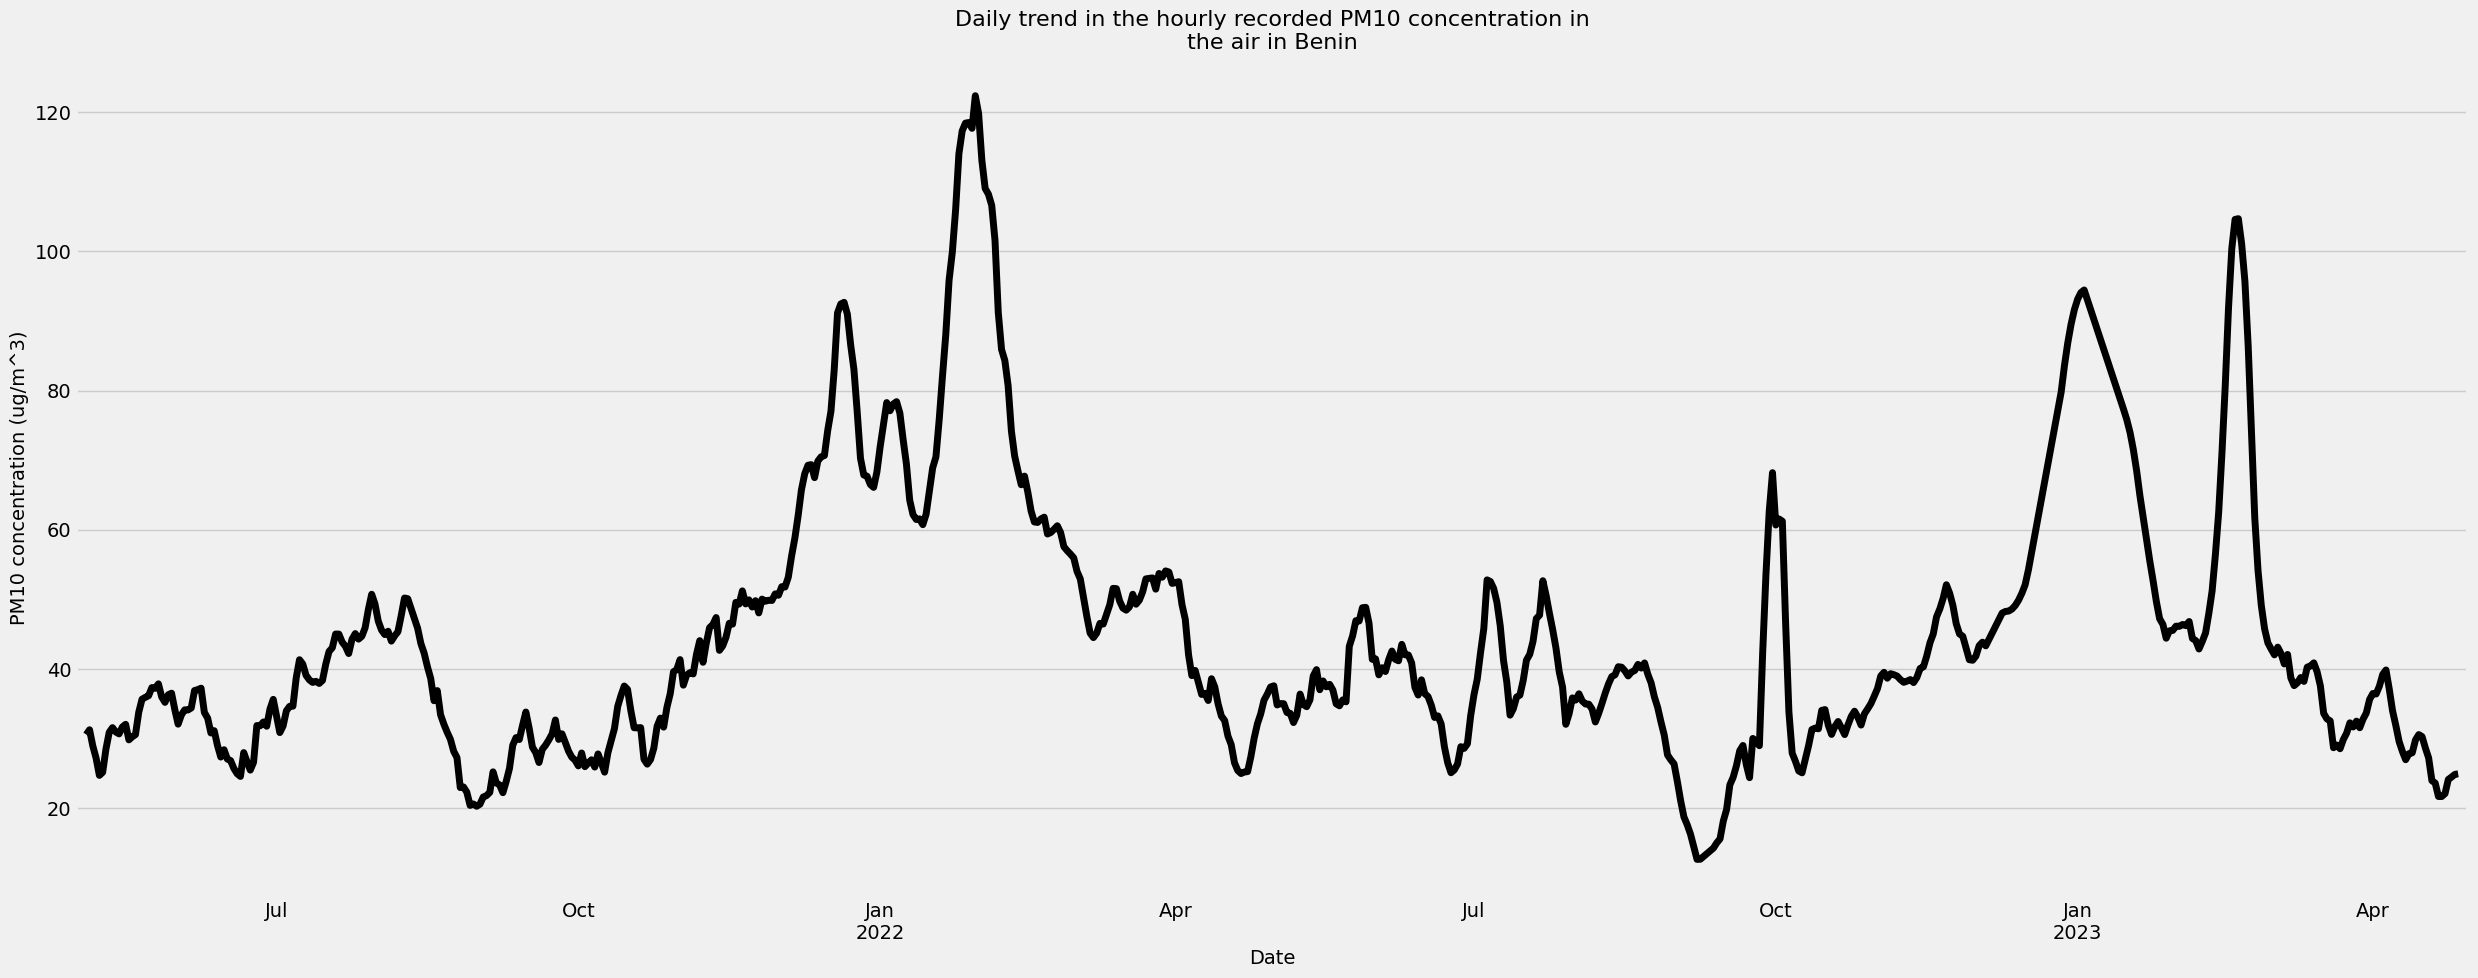

In [26]:
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM10 concentration in\nthe air in Benin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

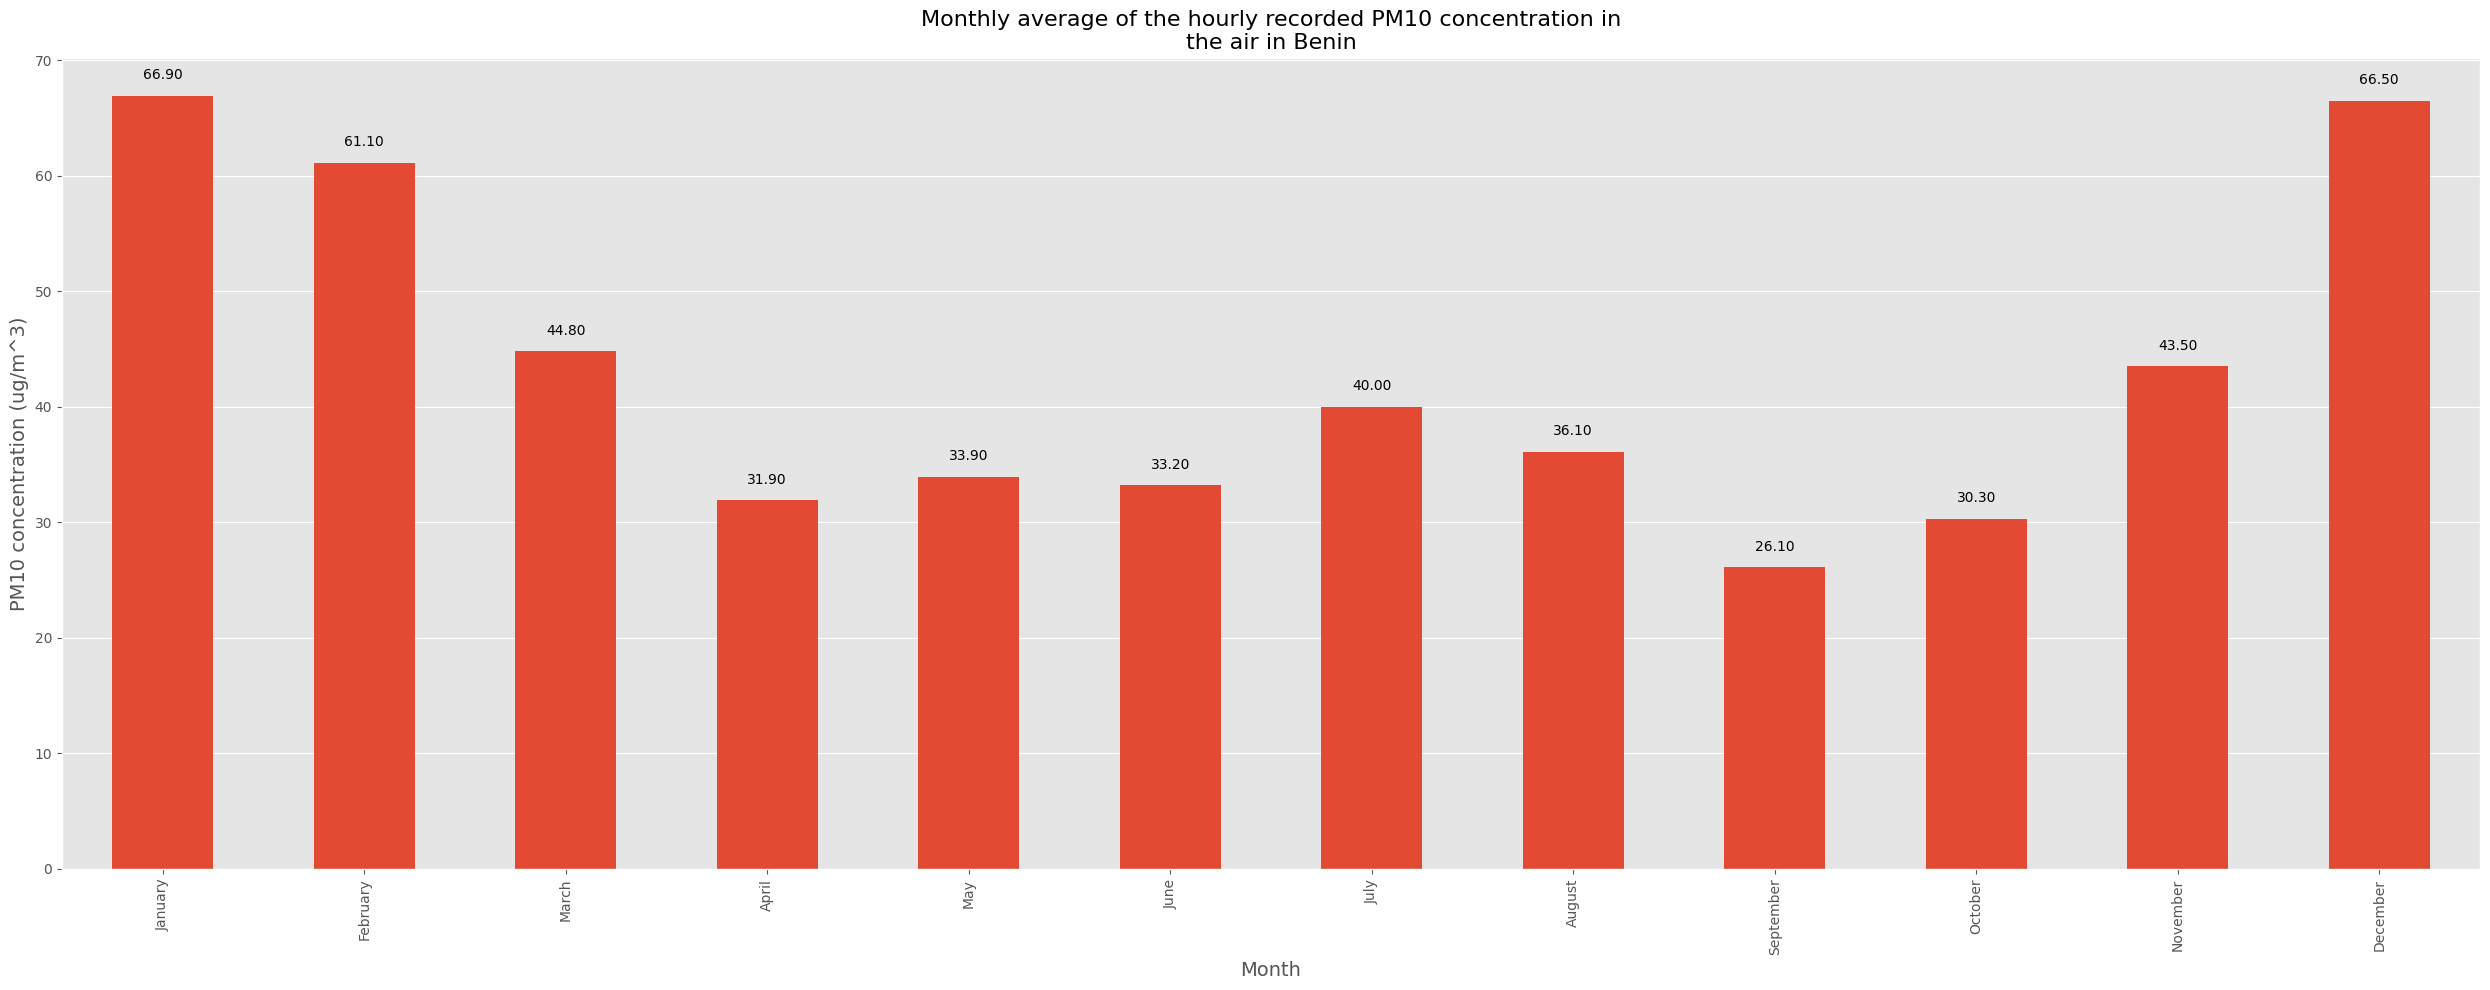

In [27]:
monthly_data = data[['Month','PM10(µg/m^3)']]
month = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(month,columns=['month'])
map_dict = {}
for i,j in enumerate(month):
    map_dict.setdefault(i+1,j)

monthly_data.Month = monthly_data.Month.map(map_dict)
monthly_average = monthly_data.groupby('Month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(25, 10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM10 concentration in\nthe air in Benin',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

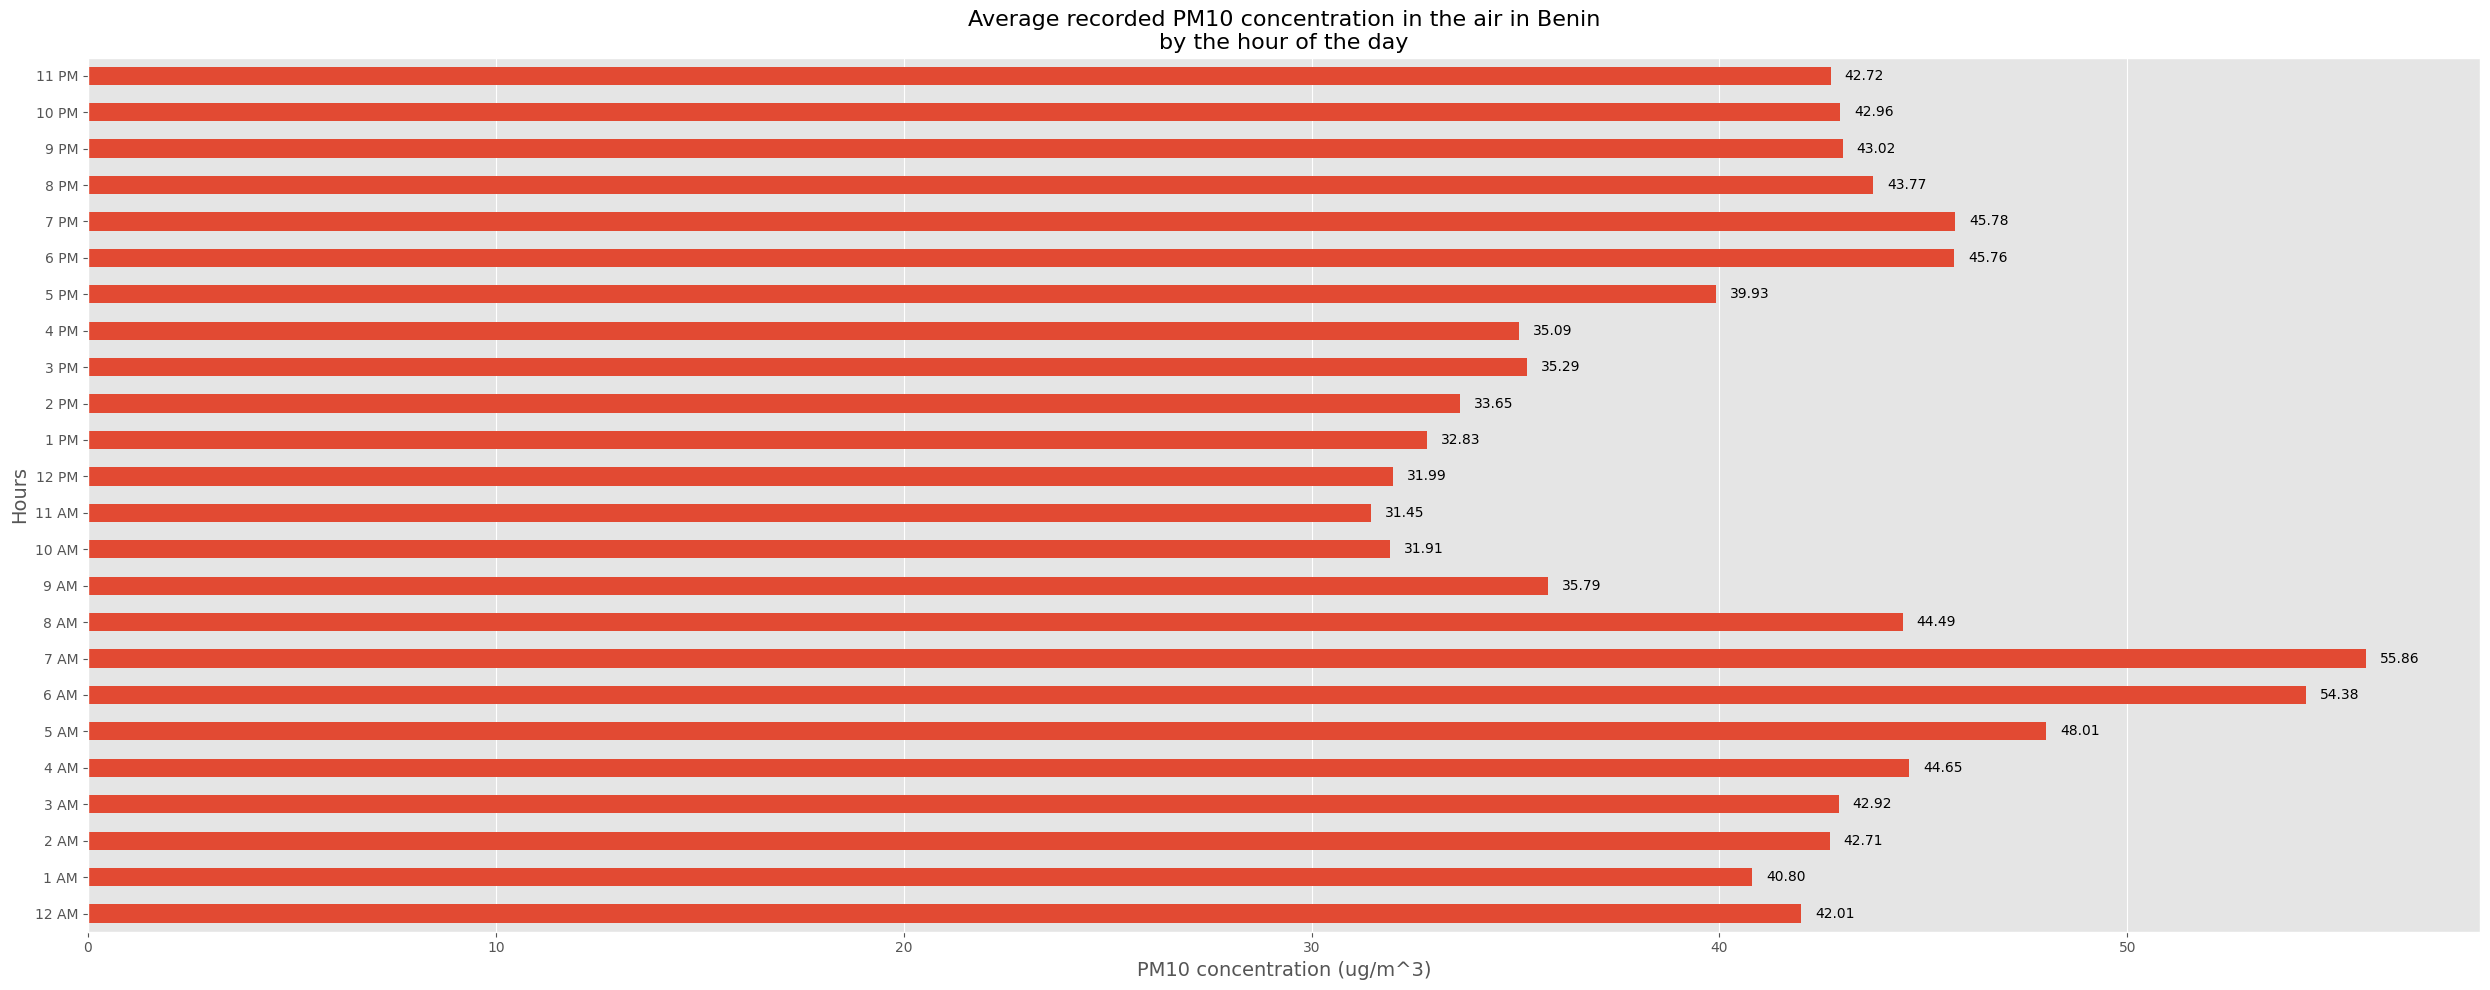

In [28]:
hourly_data = data[['Hour','PM10(µg/m^3)']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('Hour').median().reset_index()
hourly_data.Hour = hourly_data.Hour.map(hour_dict)
hourly_data = hourly_data.set_index('Hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(25,10),legend=False,kind='barh',linewidth=5)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM10 concentration in the air in Benin\nby the hour of the day',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();

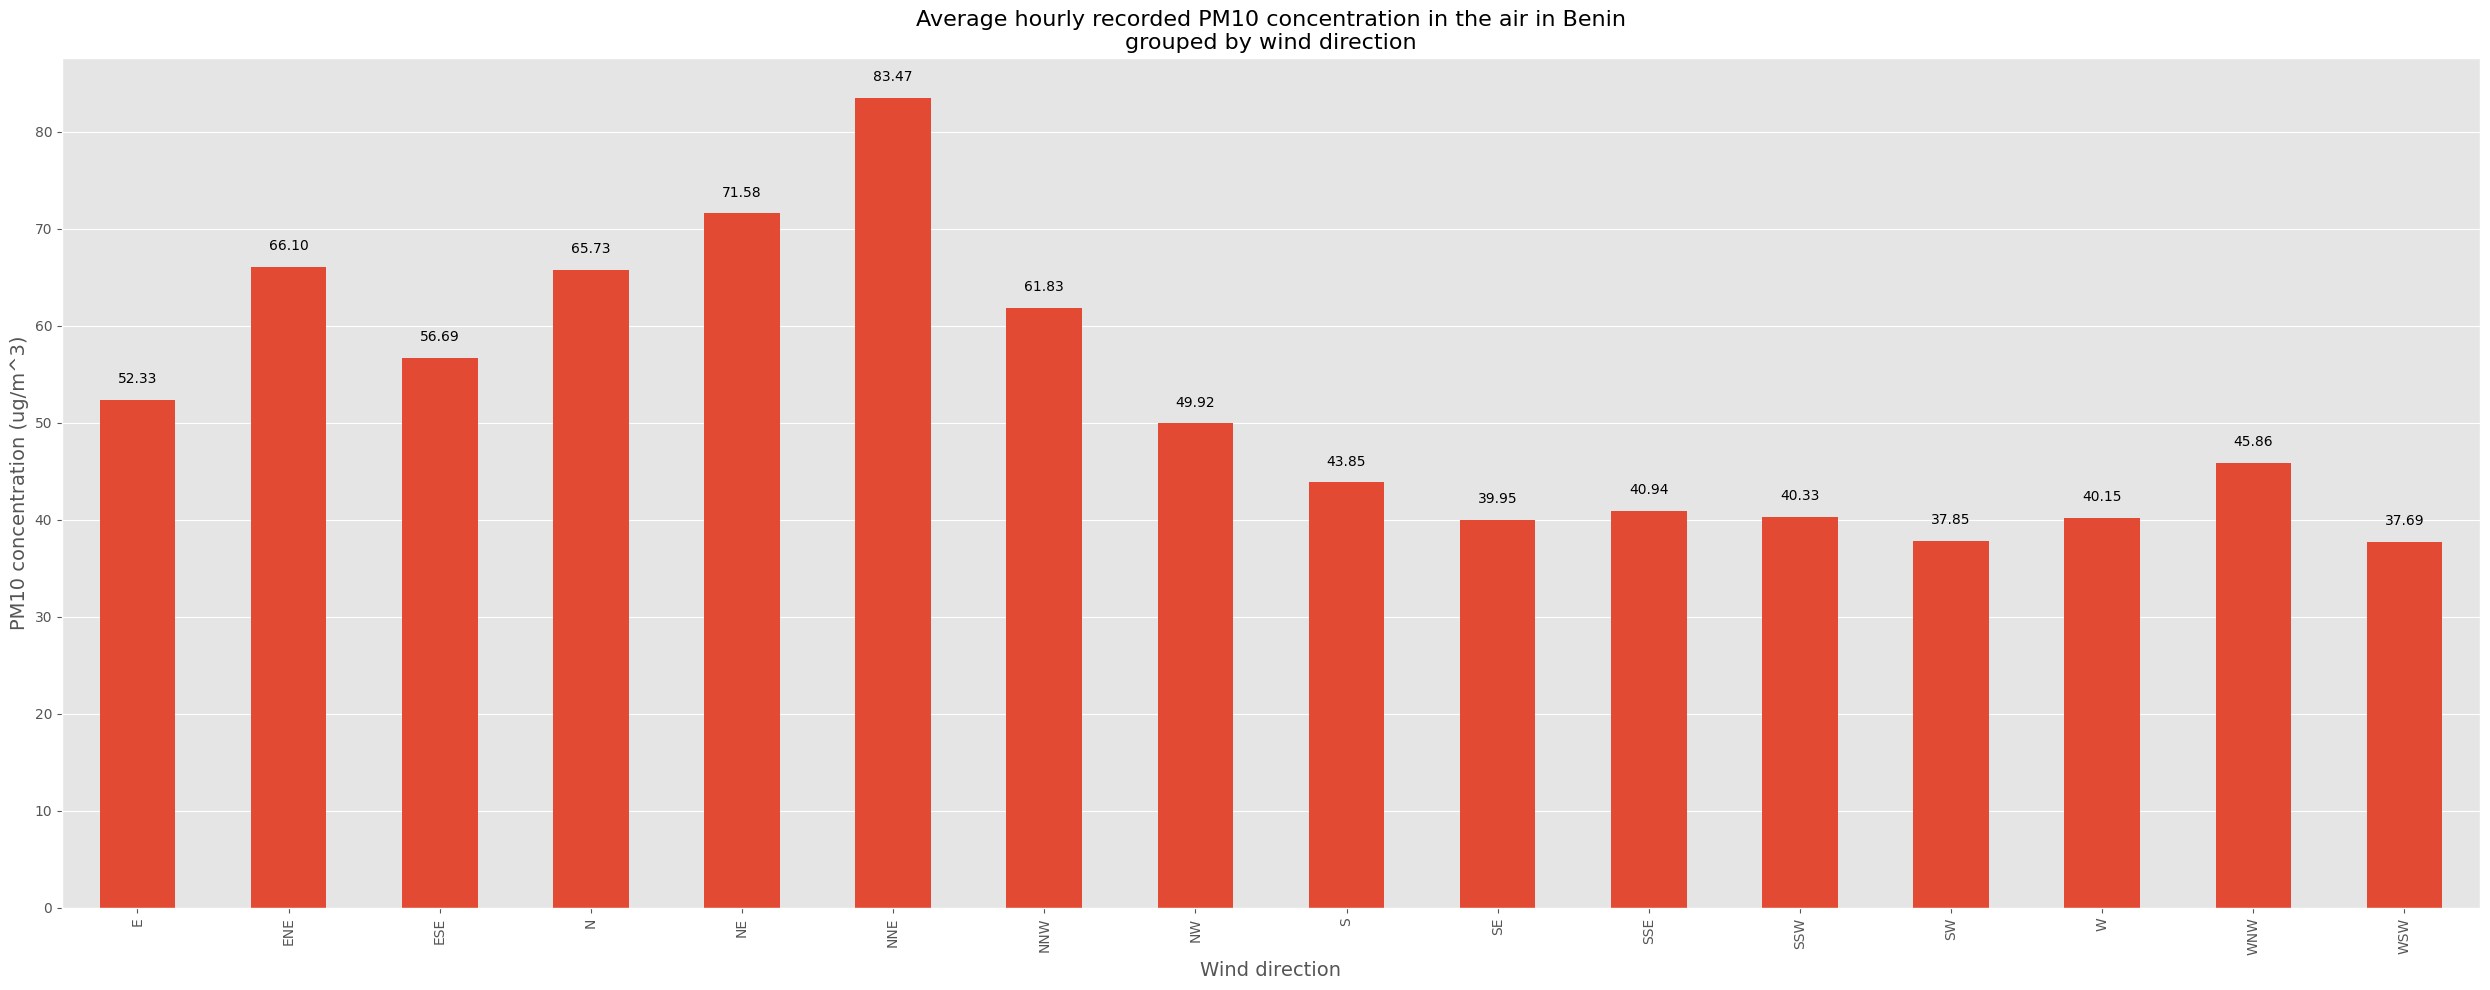

In [29]:
wind_dir = data[['Direction','PM10(µg/m^3)']]
wind_dir = wind_dir.groupby('Direction').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(25,10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM10 concentration in the air in Benin\ngrouped by wind direction',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

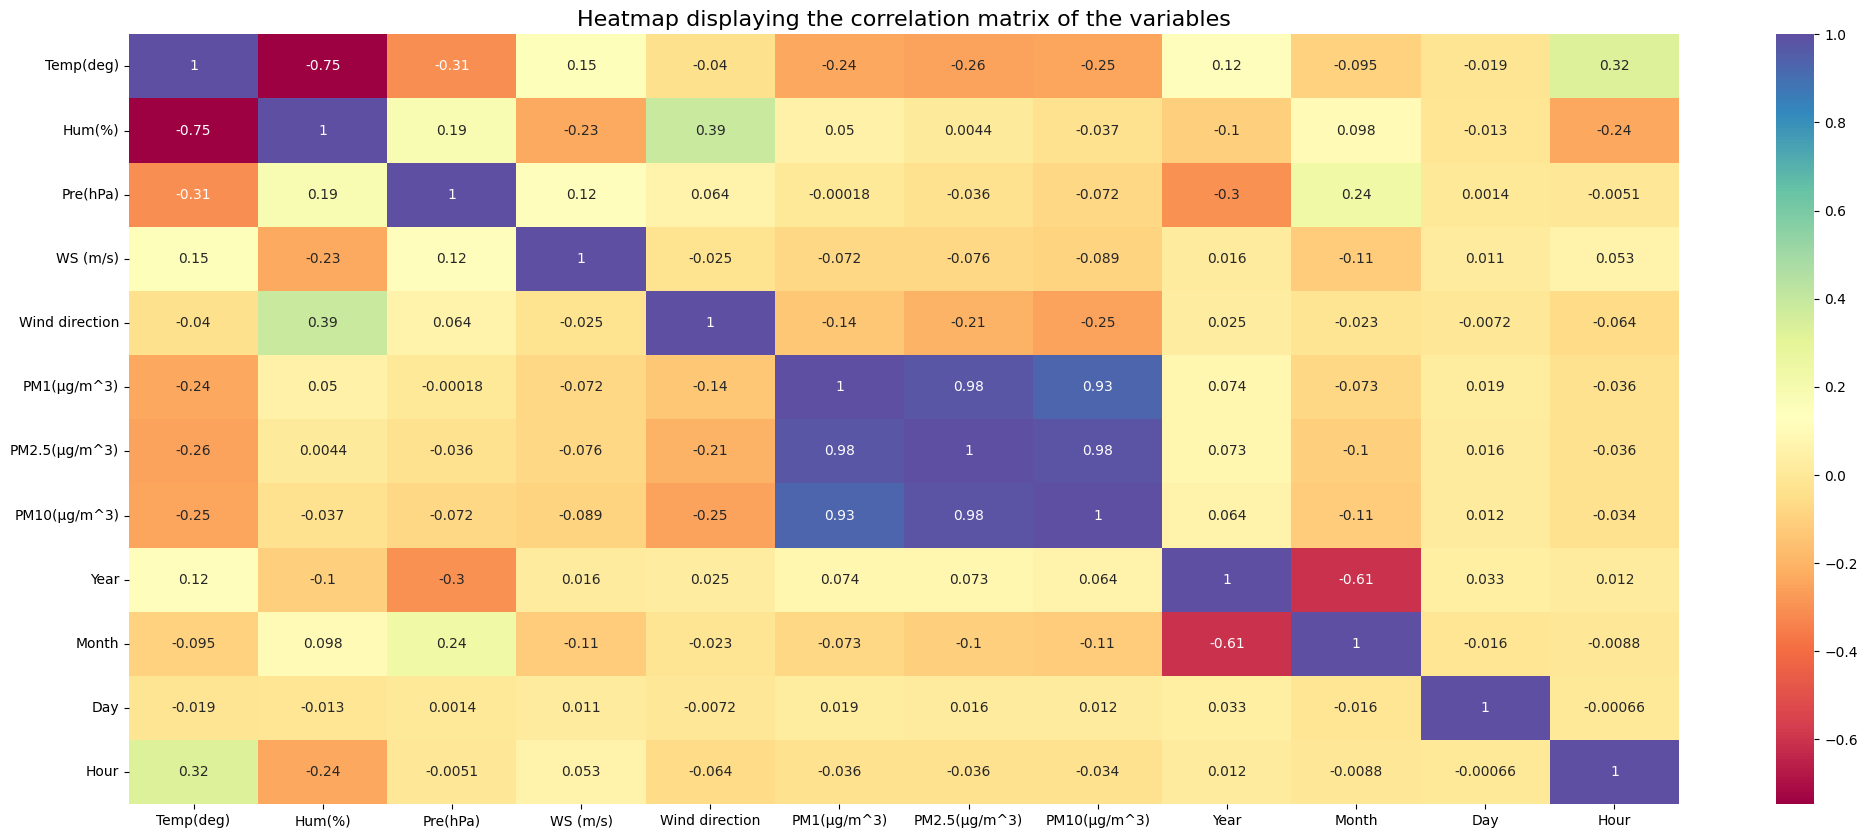

In [30]:
# Visualize the relationships between the features of the data
plt.figure(figsize=(25,10))
correlation_data = data[[ 'Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
        'Year', 'Month', 'Day', 'Hour', ]]
sns.heatmap(correlation_data.corr(),annot = True,cmap="Spectral",)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16);

Model Training and Evaluation

In [31]:
data.columns

Index(['Date', 'Time', 'Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
       'Year', 'Month', 'Day', 'Hour', 'Direction', 'E', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW'],
      dtype='object')

In [32]:
cols_to_drop = ['Date', 'Time', 'Direction' , 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)']
X = data.drop(cols_to_drop,axis=1)
y= data['PM10(µg/m^3)']

In [33]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [34]:
# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,Year,Month,Day,Hour,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,-0.269719,0.839524,-1.281988,-0.421611,0.317688,-1.107505,-0.431932,-1.704082,-1.566080,-0.101353,-0.160914,-0.081724,-0.092641,-0.168309,-0.143555,-0.088183,-0.115963,-0.1658,-0.088597,-0.110072,-0.309051,-0.707413,-0.30807,-0.162323,1.523365
1,-0.305703,0.837796,-1.559769,-0.482460,0.360411,-1.107505,-0.431932,-1.704082,-1.419405,-0.101353,-0.160914,-0.081724,-0.092641,-0.168309,-0.143555,-0.088183,-0.115963,-0.1658,-0.088597,-0.110072,-0.309051,-0.707413,-0.30807,-0.162323,1.523365
2,-0.333690,0.837796,-1.770677,-0.497673,0.412665,-1.107505,-0.431932,-1.704082,-1.272730,-0.101353,-0.160914,-0.081724,-0.092641,-0.168309,-0.143555,-0.088183,-0.115963,-0.1658,-0.088597,-0.110072,-0.309051,-0.707413,-0.30807,-0.162323,1.523365
3,-0.369674,0.842981,-1.837550,-0.406399,0.447830,-1.107505,-0.431932,-1.704082,-1.126055,-0.101353,-0.160914,-0.081724,-0.092641,-0.168309,-0.143555,-0.088183,-0.115963,-0.1658,-0.088597,-0.110072,-0.309051,-0.707413,-0.30807,-0.162323,1.523365
4,-0.385667,0.845574,-1.791253,-0.269489,0.498112,-1.107505,-0.431932,-1.704082,-0.979380,-0.101353,-0.160914,-0.081724,-0.092641,-0.168309,-0.143555,-0.088183,-0.115963,-0.1658,-0.088597,-0.110072,-0.309051,-0.707413,-0.30807,-0.162323,1.523365


In [35]:
# we now split out data into train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=53)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=53)

In [36]:
# instantiate the linear regression model
lin_model = LinearRegression()

# Fitting the model
lin_model.fit(X_train,y_train)

# Model Performance on the validation data
linear_reg_perf_test = model_performance_regression(lin_model, X_val, y_val)
linear_reg_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,25.892586,18.196064,0.191677,0.176829,56.708239


In [37]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 53)

# Fitting the model
rf_regression = rf_regressor.fit(X_train, y_train)

# Model Performance on the validation data
rf_regressor_perf_test = model_performance_regression(rf_regressor, X_val, y_val)
rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,21.718584,13.536339,0.431282,0.420835,38.924676


In [38]:
# Support Vector Machine Regression
random_state=53
svr = SVR(kernel ='linear').fit(X_train, y_train)

# Model Performance on the validation data
svr_regressor_perf_test = model_performance_regression(svr, X_val, y_val)
svr_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,26.704787,18.048843,0.140171,0.124377,50.893114


In [39]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features=None,
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(X_train,y_train)

# Model Performance on the validation data
grad_boost_perf_test = model_performance_regression(grad_boost, X_val, y_val)
grad_boost_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,22.469382,14.368357,0.391282,0.380101,41.574295


In [40]:
#Model performance comparison

models_test_comp_df = pd.concat(
    [
        linear_reg_perf_test.T,
        rf_regressor_perf_test.T,
        svr_regressor_perf_test.T,
        grad_boost_perf_test.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Multiple Linear Regression",
    "Random Forest ",
    "Support Vector Machine",
    "Gradient Boosting",
    ]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Multiple Linear Regression,25.892586,18.196064,0.191677,0.176829,56.708239
Random Forest,21.718584,13.536339,0.431282,0.420835,38.924676
Support Vector Machine,26.704787,18.048843,0.140171,0.124377,50.893114
Gradient Boosting,22.469382,14.368357,0.391282,0.380101,41.574295


In [41]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Multiple Linear Regression,25.892586
1,MAE,Multiple Linear Regression,18.196064
2,R-squared,Multiple Linear Regression,0.191677
3,Adj. R-squared,Multiple Linear Regression,0.176829
4,MAPE,Multiple Linear Regression,56.708239
5,RMSE,Random Forest,21.718584
6,MAE,Random Forest,13.536339
7,R-squared,Random Forest,0.431282
8,Adj. R-squared,Random Forest,0.420835
9,MAPE,Random Forest,38.924676


In [42]:
def plot_model_comparison(df_melted):
  """
  Generates a bar chart for model comparison.

  Args:
    df_melted: A pandas DataFrame in melted format, containing the model performance metrics.

  Returns:
    None. Displays the bar chart.
  """

  # Create a list of subplots
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

  # Loop through each index value and create a bar chart for each
  for i, index in enumerate(df_melted['index'].unique()):
      # Filter the data for the current index value
      data = df_melted[df_melted['index'] == index]

      # Create a bar chart
      axes[i].bar(data['Model'], data['Value'])
      axes[i].set_title(index)
      axes[i].tick_params(axis='x', labelrotation=90)
      axes[i].bar_label(axes[i].containers[0], fmt='%.2f', padding=12)

  plt.show()  # Display the chart

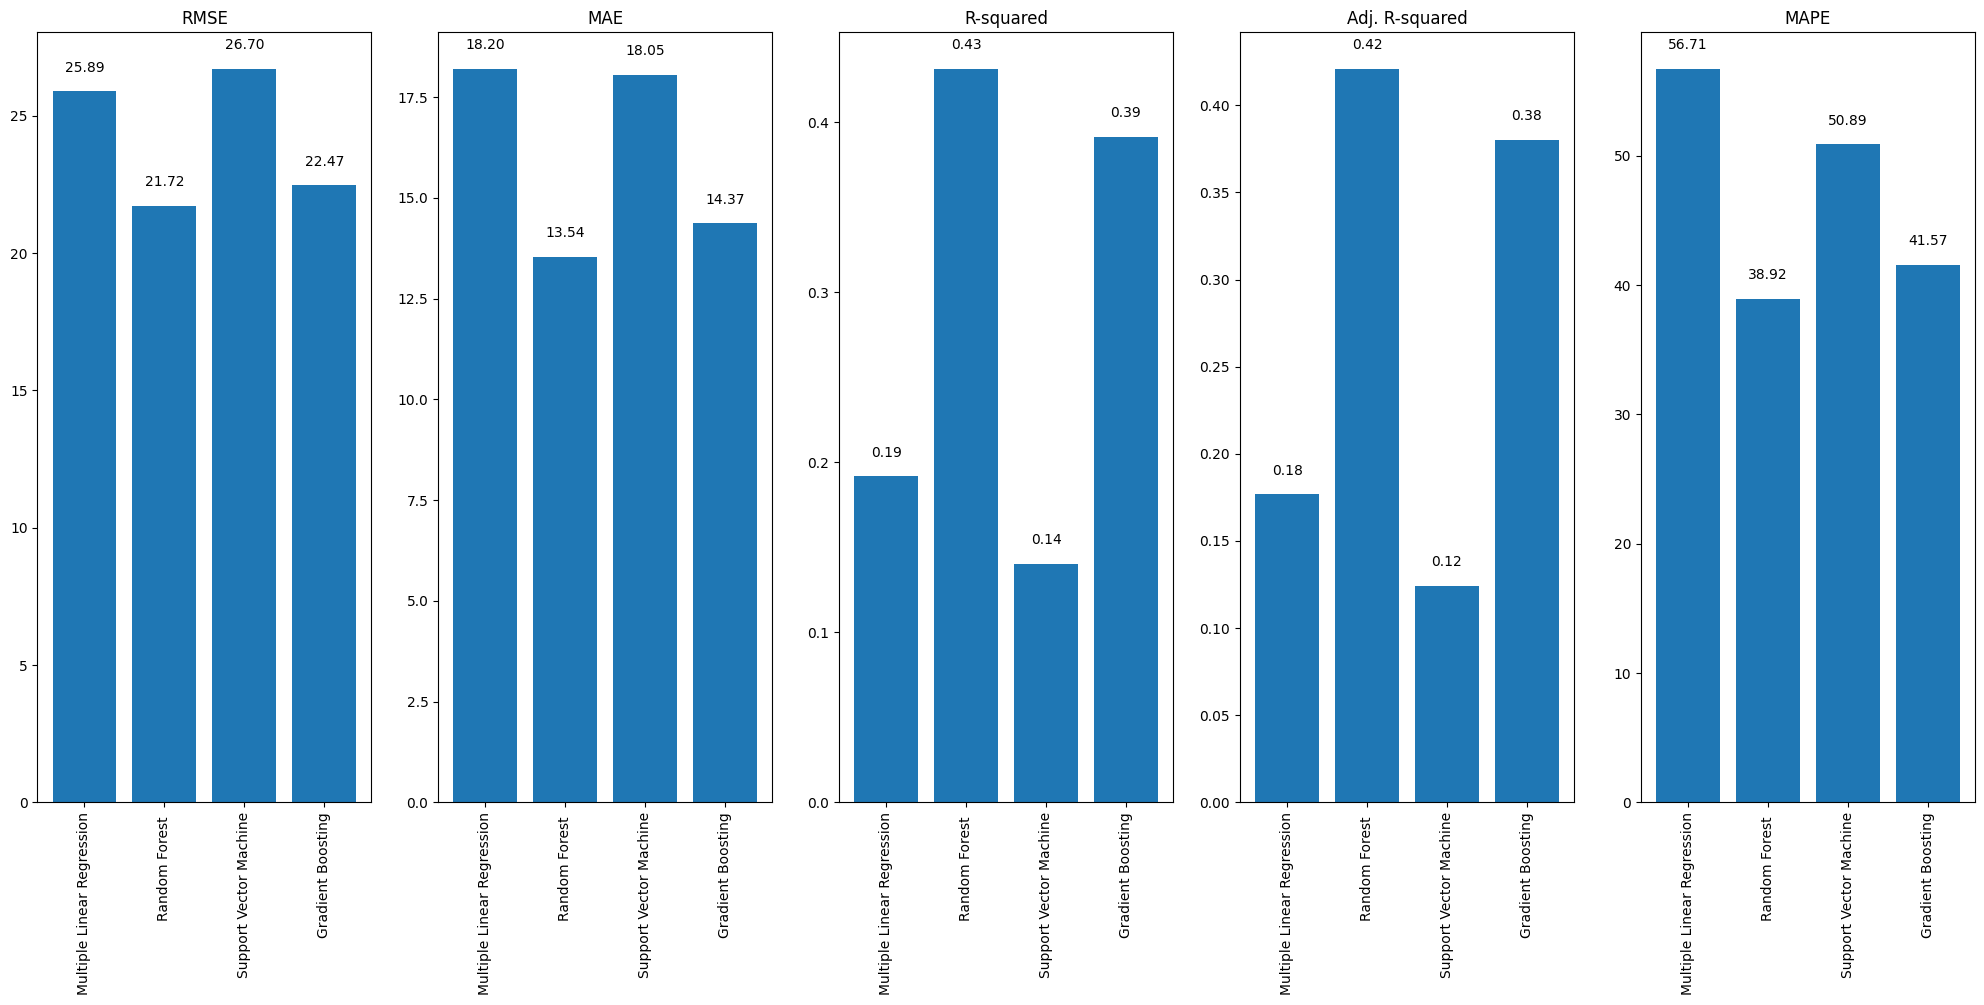

In [43]:
plot_model_comparison(df_melted)

In [44]:
#Hyperparameter tunning for Random Forest

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(50, 501, 50),  # Expanded range
    'max_depth': [None, 5, 10, 20],  # Added values
    'min_samples_split': np.arange(2, 11, 2),  # Expanded range
    'min_samples_leaf': np.arange(1, 5, 1),  # Added values
    'max_features': [None, 'sqrt', 'log2'],  # Added options
    'bootstrap': [True, False],  # Added option
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Evaluation metric
    random_state=53,  # For reproducibility
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

In [45]:
best_params = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
# Random Forest Regressor
best_model = RandomForestRegressor(**best_params)

# Fitting the model
best_model = best_model.fit(X_train, y_train)

# Evaluate the tuned random forest model on the validation data
RF_tuned_model =  model_performance_regression(best_model, X_val, y_val)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,21.543749,13.3689,0.440402,0.430122,38.243077


In [46]:
#Fine tuned model performance comparison

models_test_comp_df = pd.concat(
    [
        rf_regressor_perf_test.T,
        RF_tuned_model.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Random Forest ",
    "Fine-tuned Random Forest",
    ]


print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Random Forest,21.718584,13.536339,0.431282,0.420835,38.924676
Fine-tuned Random Forest,21.543749,13.368900,0.440402,0.430122,38.243077


In [47]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Random Forest,21.718584
1,MAE,Random Forest,13.536339
2,R-squared,Random Forest,0.431282
3,Adj. R-squared,Random Forest,0.420835
4,MAPE,Random Forest,38.924676
5,RMSE,Fine-tuned Random Forest,21.543749
6,MAE,Fine-tuned Random Forest,13.368900
7,R-squared,Fine-tuned Random Forest,0.440402
8,Adj. R-squared,Fine-tuned Random Forest,0.430122
9,MAPE,Fine-tuned Random Forest,38.243077


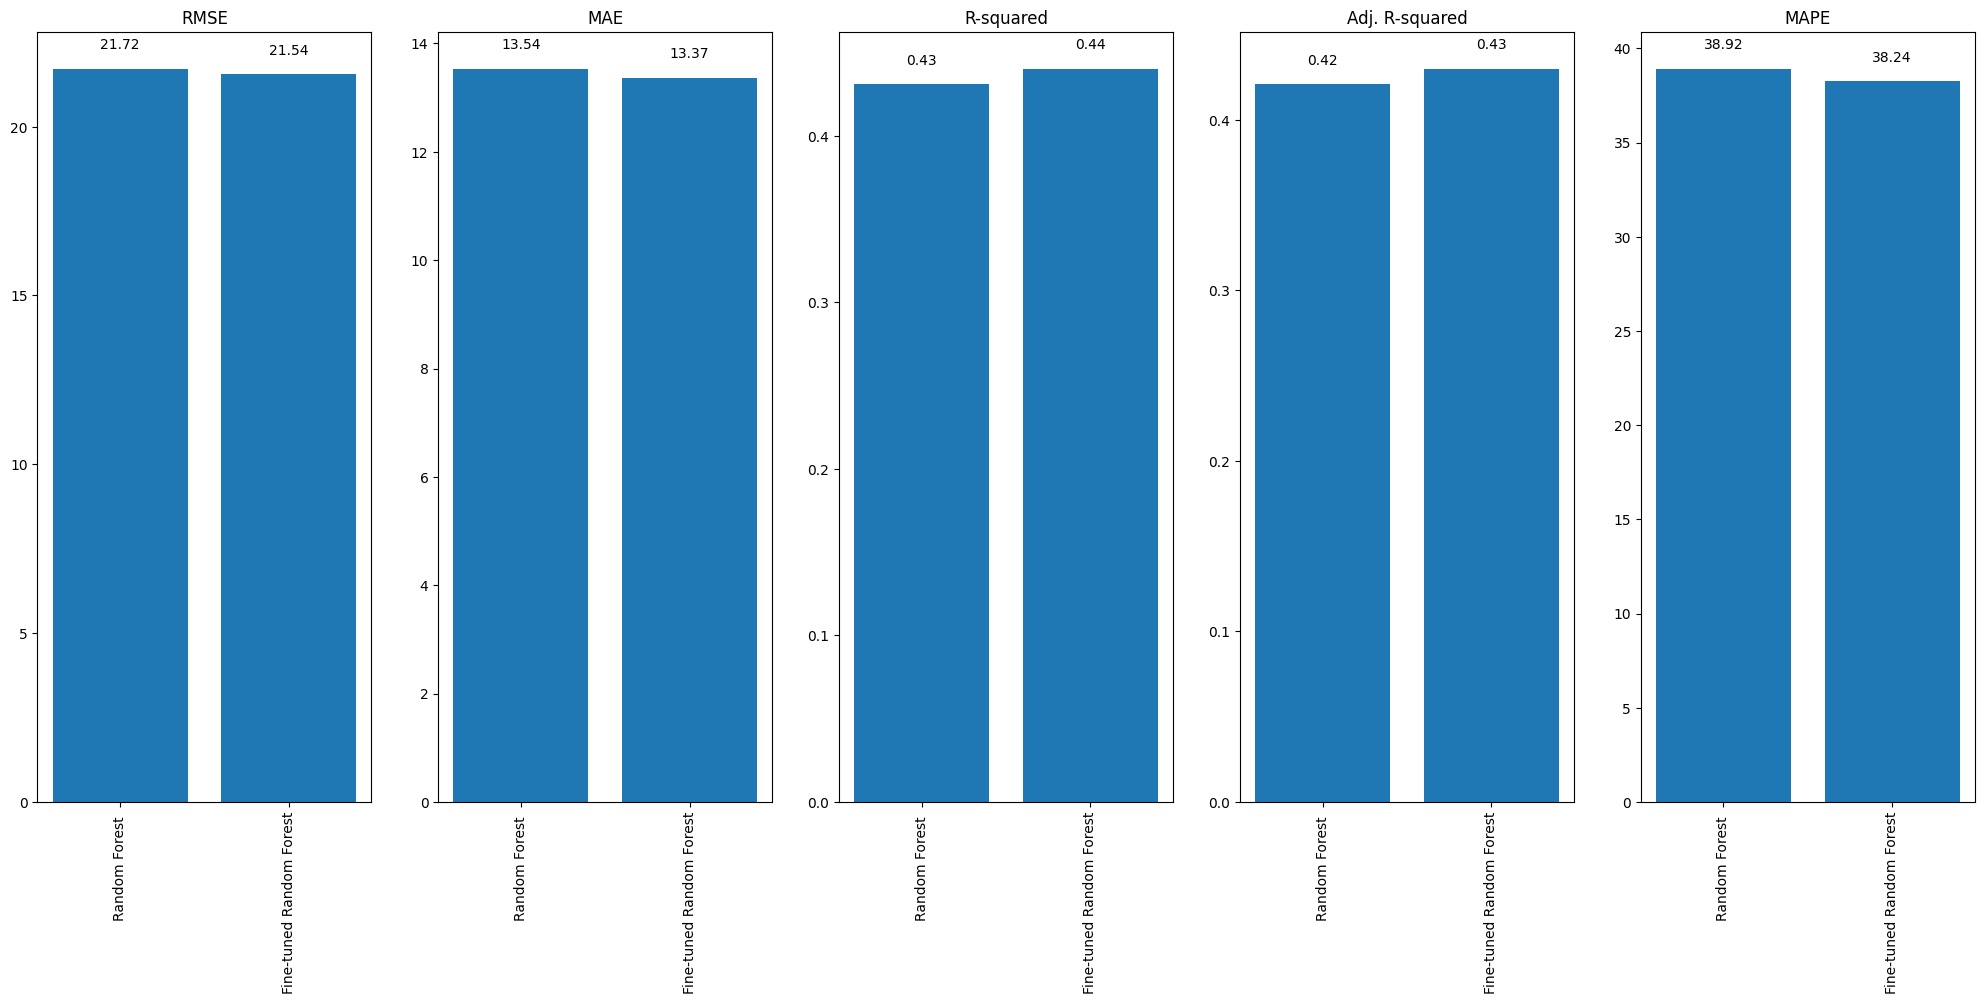

In [48]:
plot_model_comparison(df_melted)

In [49]:
# Evaluate the best model on the test data
RF_tuned_model =  model_performance_regression(best_model, X_test, y_test)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,22.152254,14.215182,0.458476,0.448528,40.28116


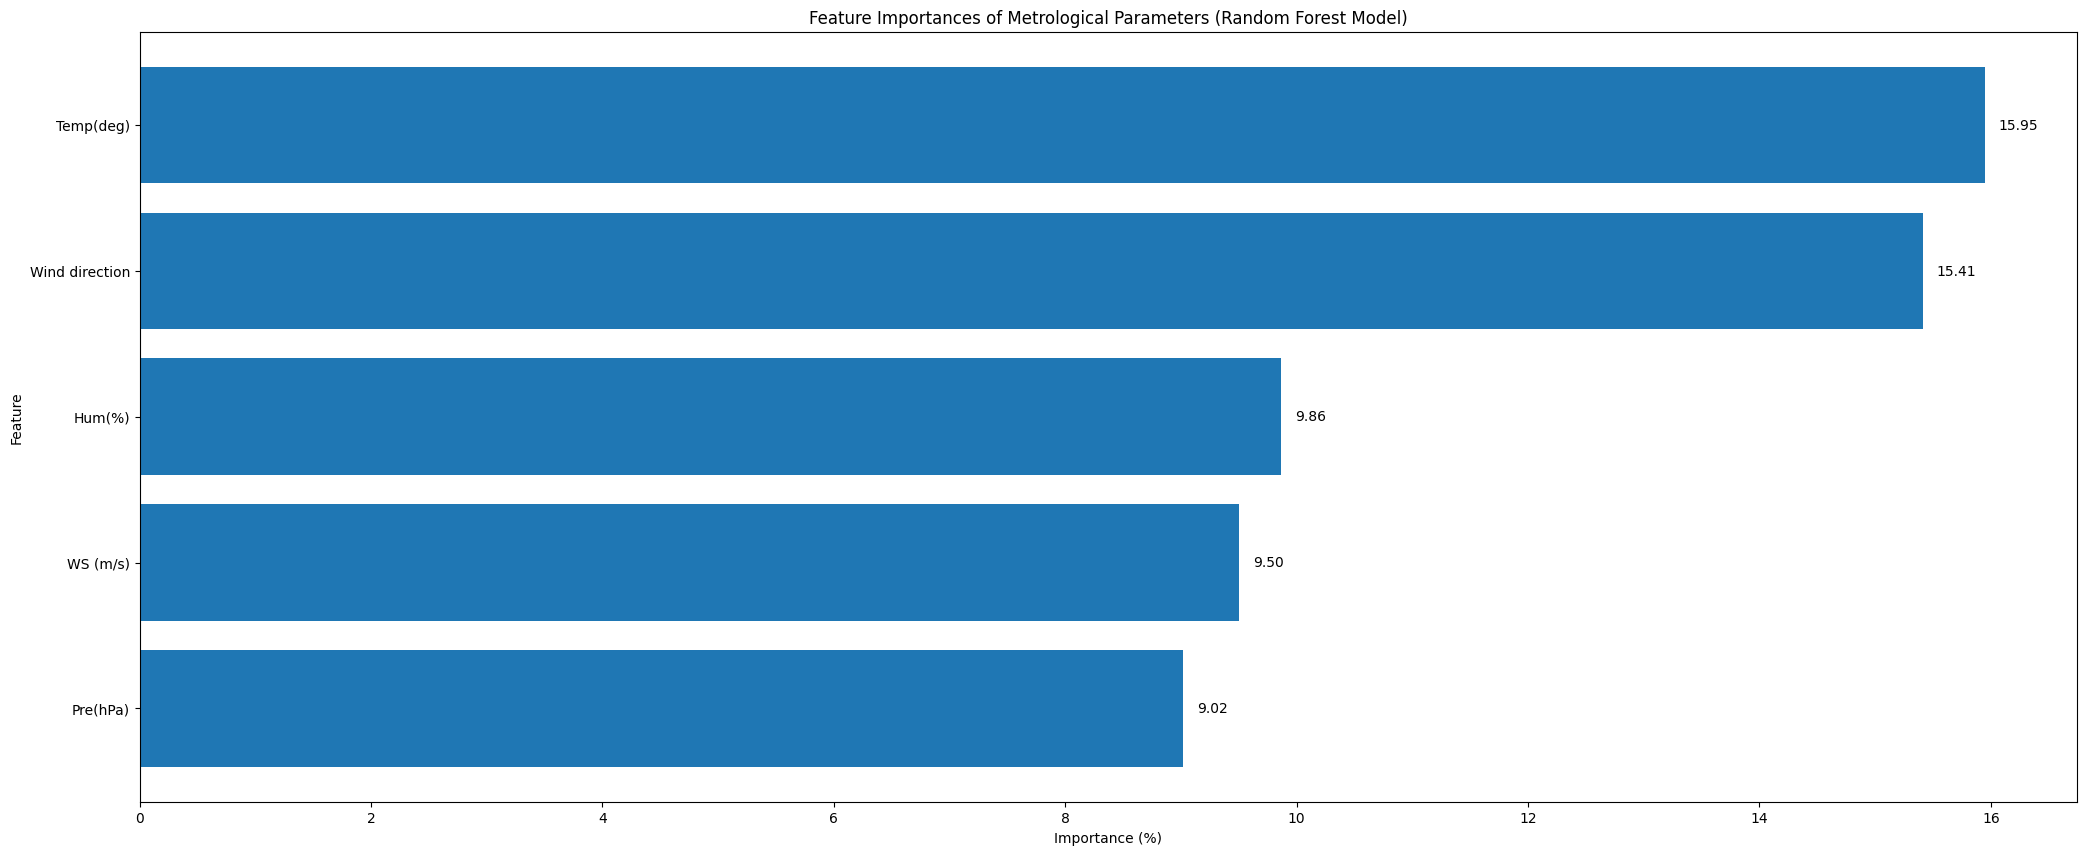

In [50]:
# Feature importance of the best model (Random Forest model)
# Get feature importances
importances = best_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort importances and feature names
importances, feature_names = zip(*sorted(zip(importances*100, feature_names)))

#Keep only Metrological Features
features_to_keep = ['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)','Wind direction']

importance =  [importance for importance, feature_name in zip(importances, feature_names) if feature_name in features_to_keep]
feature_names = [name for name in feature_names if name in features_to_keep]

# Create a vertical bar chart
plt.figure(figsize=(25, 10))
plt.barh(feature_names, importance)

# Show plot

# Get the current Axes object
ax = plt.gca()
# Add value labels on top of bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=10)

# Set title and axis labels
plt.title("Feature Importances of Metrological Parameters (Random Forest Model)")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")

# Show the plot
plt.show();

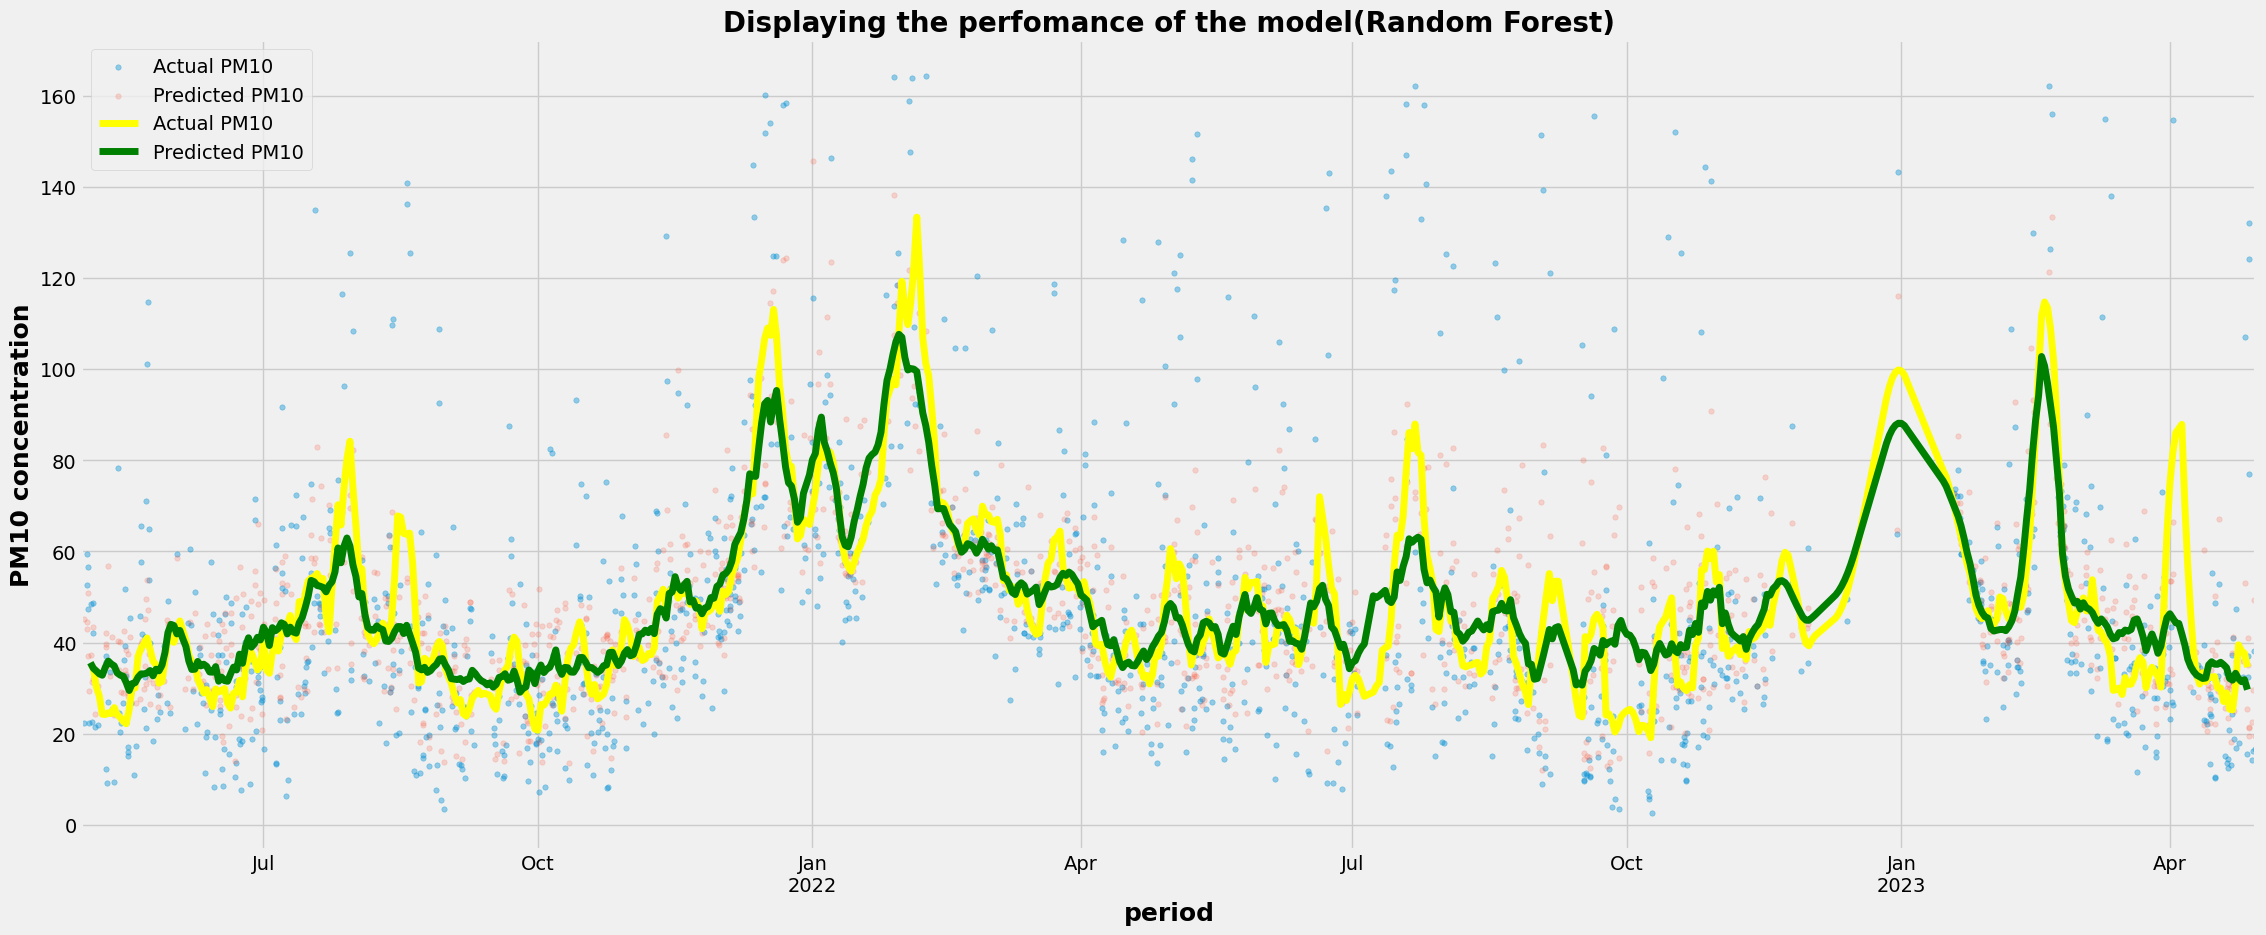

In [51]:
# we now use the best model (Random forest model) to predict the PM10
# concetration and compare it to the actual PM10 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'Actual PM10':y_test,
                            'Predicted PM10':best_model.predict(X_test.values)})
colors = {
    "Actual PM10": "yellow",
    "Predicted PM10": "green",
}

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.4)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.2)

    compare_daily_data = compare_data.resample('D').median()
    compare_daily_data.interpolate(inplace=True)

    for column in compare_daily_data.columns:
      decomposition = seasonal_decompose(compare_daily_data[column], model='addictive')
      # plot the data
      decomposition.trend.plot(linestyle='-', alpha =1, color=colors.get(column, "grey"), linewidth=5,legend=True, label=column)

    plt.legend()
    plt.title('Displaying the perfomance of the model(Random Forest)',
             fontsize=20, fontweight='bold')
    plt.xlabel('period',fontsize=18, fontweight='bold')
    plt.ylabel('PM10 concentration',fontsize=18, fontweight='bold')
    plt.show();

In [52]:
# Linear fitting of predicted and actual values for the best model (Random Forest model)
lr = LinearRegression()
lr.fit(compare_data['Predicted PM10'].values.reshape(-1,1), compare_data['Actual PM10'])

# Make predictions using the linear regression model
predicted_values_lr = lr.predict(compare_data['Predicted PM10'].values.reshape(-1,1))

# Evaluate the model
r_squared = r2_score(compare_data['Actual PM10'], predicted_values_lr)
r_squared

0.46293038345597737

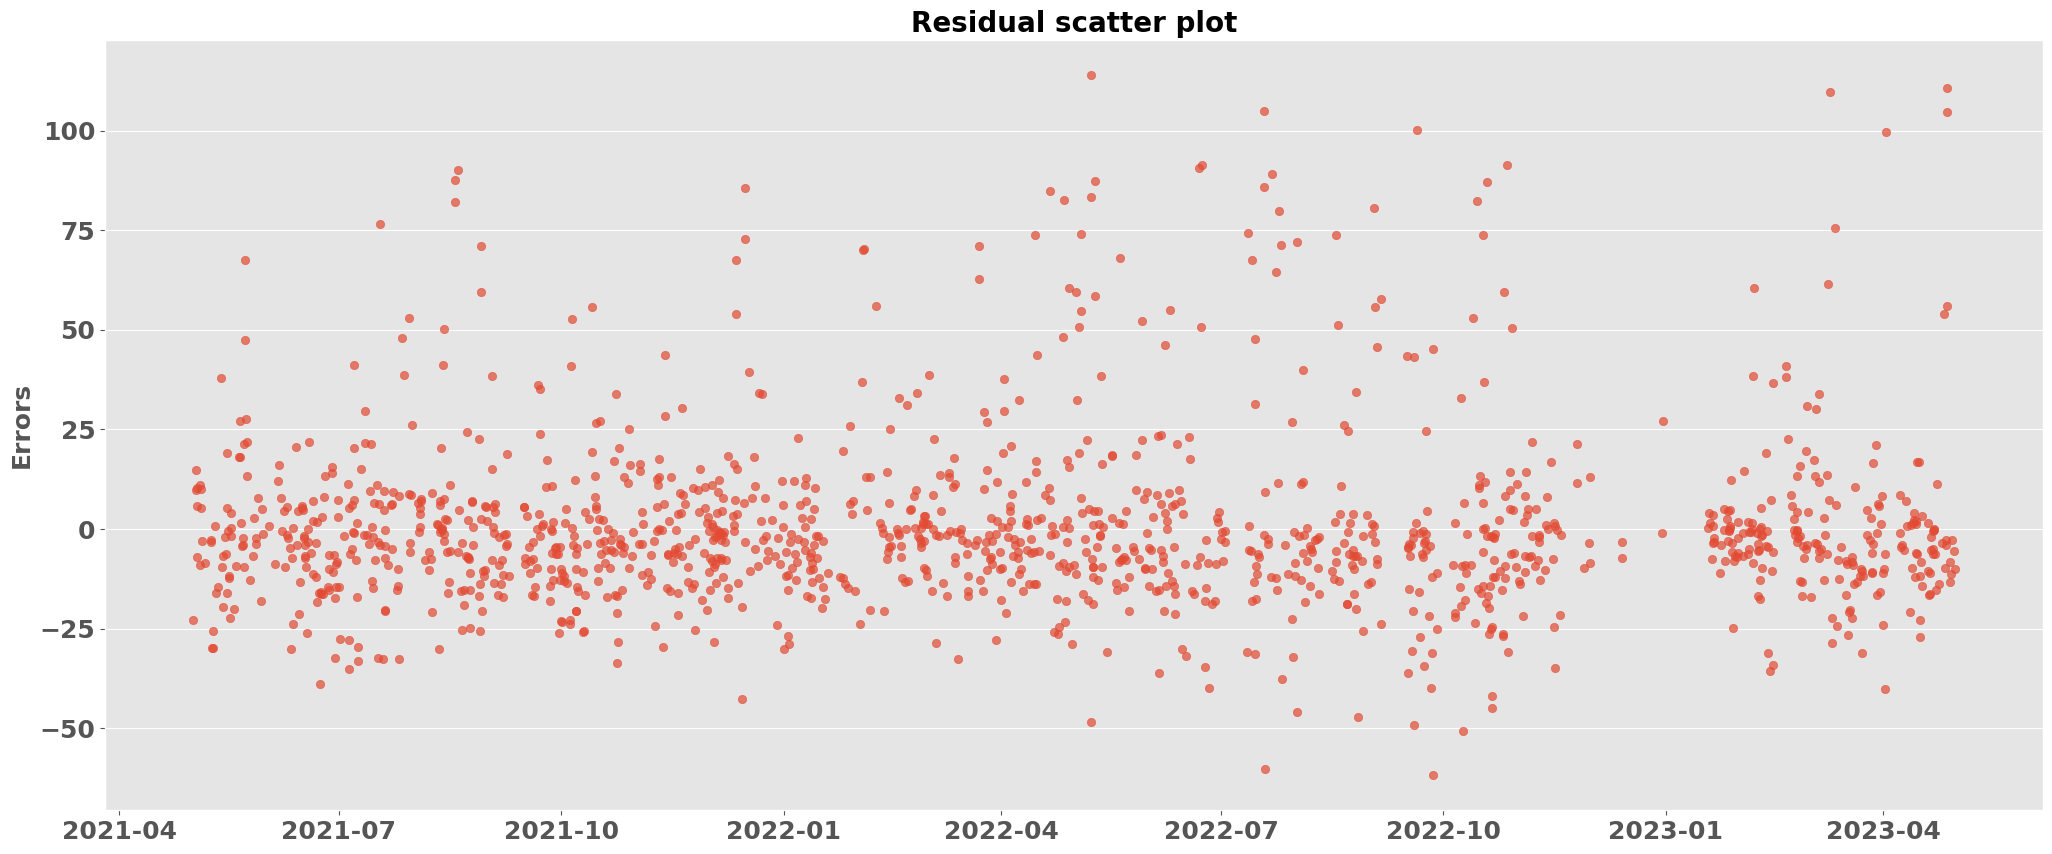

In [53]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM10'] - compare_data['Predicted PM10']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=20, fontweight='bold')
    plt.ylabel('Errors',fontsize=18, fontweight='bold')
    plt.grid(axis='x')
    # Get the current Axes object
    ax = plt.gca()
    # Increase the size of the x and y tick labels
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set the font weight to bold for x and y tick labels
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.show();

<Figure size 2500x1000 with 0 Axes>

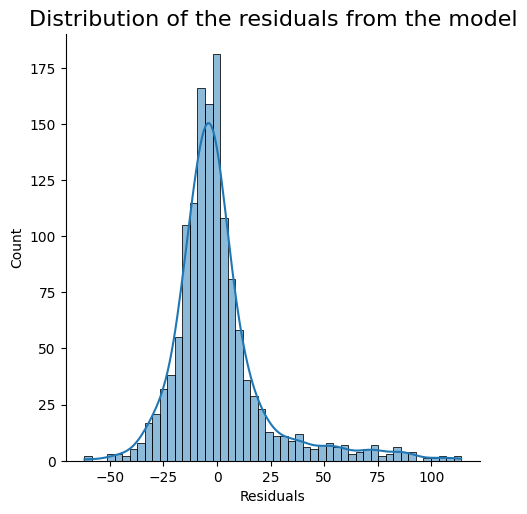

In [54]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(25,10))
sns.displot(compare_data.Residuals,bins=50, kde=True , lw=5)
plt.title('Distribution of the residuals from the model',
         fontsize=16)
plt.show();